# 🏦 Problema de abandono de clientes - Kaggle Competition
### 📌 Vicky Crosina
Analiza el abandono de clientes bancarios, entrenando modelos predictivos RandomForest y XGBoost.


/kaggle/input/competicion-problema-de-churn-en-banco/sample_submission.csv
/kaggle/input/competicion-problema-de-churn-en-banco/train.csv
/kaggle/input/competicion-problema-de-churn-en-banco/test.csv
id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
ROC AUC: 0.8970951363059059
ROC AUC mejorado: 0.9192271273700446
Fitting 3 folds for each of 48 candidates, totalling 144 fits
ROC AUC con modelo XGBClassifier optimizado (GridSearchCV): 0.9333552571895128


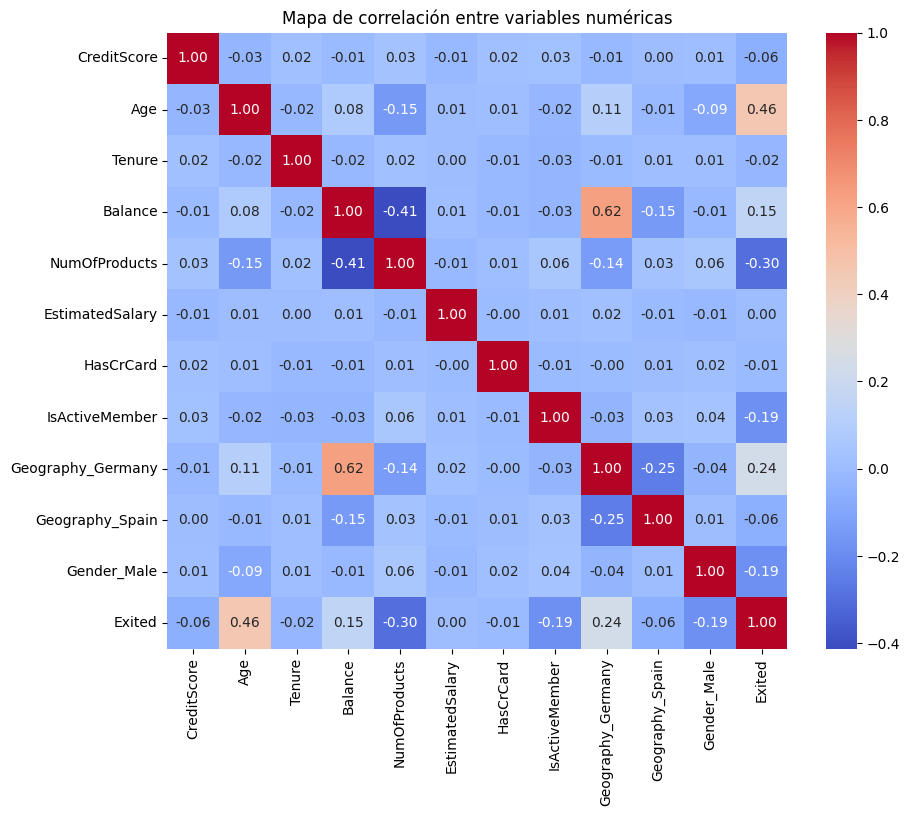

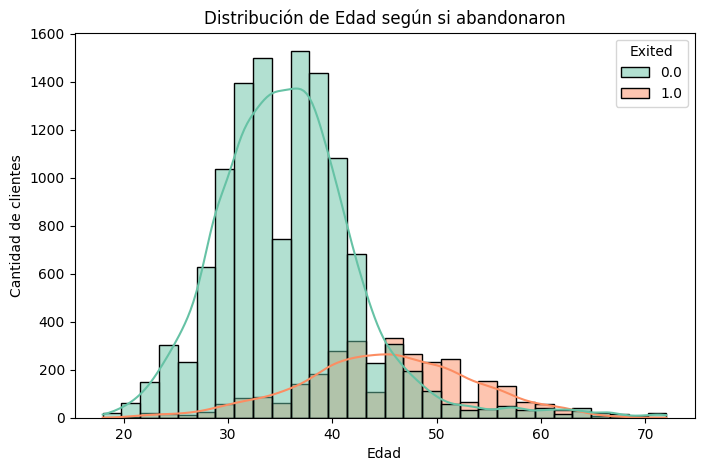

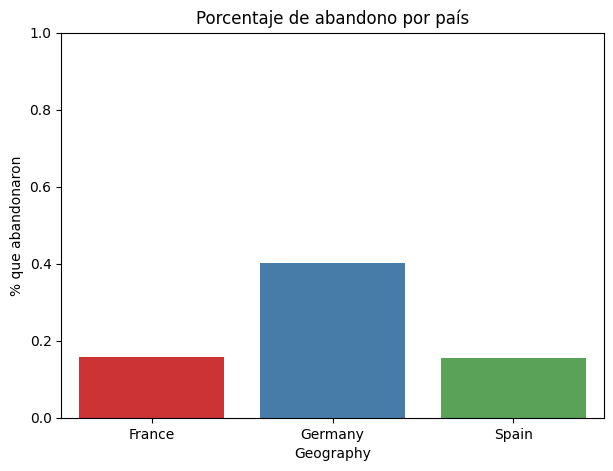

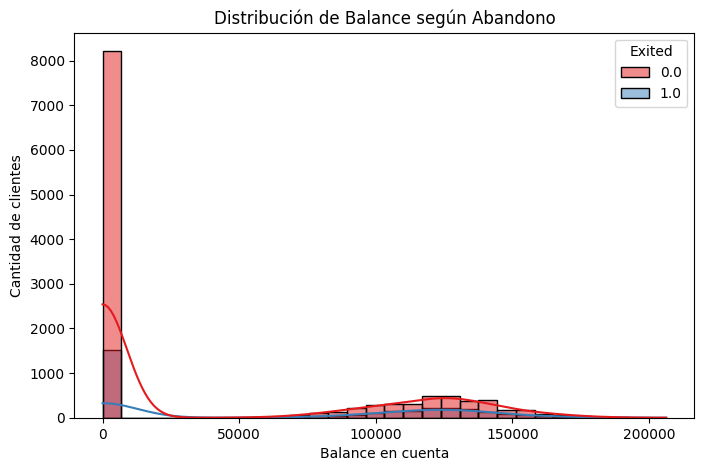

In [3]:
#------------------------Competición - Problema de abandono en banco - Vicky-------------------------#

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Saco los warnings que quedan feos para visualizar 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Cargar archivos 
df_train = pd.read_csv('/kaggle/input/competicion-problema-de-churn-en-banco/train.csv')
df_test = pd.read_csv('/kaggle/input/competicion-problema-de-churn-en-banco/test.csv')
df_plot = pd.read_csv('/kaggle/input/competicion-problema-de-churn-en-banco/train.csv')

# primeras filas
df_train.head()

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Verificaciones varias...
print(df_train.isnull().sum())
target = 'Exited'  # Es la que indica si el cliente se fue o no

# Variables
features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
X = df_train[features]
y = df_train[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------------------------------Modelo RandomForest -----------------------------------------------#
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluacion 
y_pred = model.predict_proba(X_val)[:, 1]
print('ROC AUC:', roc_auc_score(y_val, y_pred))

# Marcar la diferencia. 
df_train['is_train'] = 1
df_test['is_train'] = 0
df_test['Exited'] = -1  # dummy para combinar

# Unir 
df_all = pd.concat([df_train, df_test], axis=0)

# Caregorias
df_all = pd.get_dummies(df_all, columns=['Geography', 'Gender'], drop_first=True)

# Habia nulos porque lo vi en un comentario de discord.. 

df_all['HasCrCard'] = df_all['HasCrCard'].fillna(0) #df_all['HasCrCard'].fillna(0, inplace=True) me tiro una advertencia y lo cambie

# separo aca
df_train = df_all[df_all['is_train'] == 1].drop(['is_train'], axis=1)
df_test = df_all[df_all['is_train'] == 0].drop(['is_train', 'Exited'], axis=1)

# Comento el código para hacer un update capaz ahí subo el score
features = [
    'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
    'EstimatedSalary', 'HasCrCard', 'IsActiveMember',
    'Geography_Germany', 'Geography_Spain', 'Gender_Male'
]

X = df_train[features]
y = df_train['Exited']

# Entrenamiento del modelo mejorado
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
print("ROC AUC mejorado:", roc_auc_score(y_val, y_pred))

X_test = df_test[features]
y_test_pred = model.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    'id': df_test['id'],
    'Exited': y_test_pred
})

submission.to_csv('/kaggle/working/submission.csv', index=False)
submission.head()

#------------------------------------------------ ini Modelo XGBoost-----------------------------------#
#
#import xgboost as xgb
#from sklearn.metrics import roc_auc_score
#from sklearn.model_selection import train_test_split
#
# Uso el mismo set de features mejorado
#X = df_train[features]
#y = df_train['Exited']
#
# Split
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
#
# Crear modelo
#xgb_model = xgb.XGBClassifier(
#    n_estimators=300,
#    learning_rate=0.05,
#    max_depth=4,
#    use_label_encoder=False,
#    eval_metric='auc',
#    random_state=42
#)
#
# Entrenar modelo
#xgb_model.fit(X_train, y_train)
#
# Evaluar
#y_pred = xgb_model.predict_proba(X_val)[:, 1]
#print("ROC AUC con XGBoost:", roc_auc_score(y_val, y_pred))
#
# Predicciones sobre test
#X_test = df_test[features]
#y_test_pred = xgb_model.predict_proba(X_test)[:, 1]
#
# Crear el archivo de submission
#submission = pd.DataFrame({
#    'id': df_test['id'],
#    'Exited': y_test_pred
#})
#
#submission.to_csv('/kaggle/working/submission_xgb.csv', index=False)
#submission.head()

#------------------------------------------------ fin Modelo XGBoost-----------------------------------#


#------------------------------------------------ ini Modelo XGB---------------------------------------#
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Configurar el espacio de búsqueda
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42
)

# Aplicar GridSearchCV
grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

# Evaluar mejor modelo encontrado
best_model = grid.best_estimator_
y_pred = best_model.predict_proba(X_val)[:, 1]
print("ROC AUC con modelo XGBClassifier optimizado (GridSearchCV):", roc_auc_score(y_val, y_pred))

# Predicciones finales
X_test = df_test[features]
y_test_pred = best_model.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    'id': df_test['id'],
    'Exited': y_test_pred
})

submission.to_csv('/kaggle/working/submission_xgb_tuned.csv', index=False)
submission.head()


#------------------------------------------------ fin Modelo XGB---------------------------------------#


#------------------------------------------------INICIO DE GRAFICAS------------------------------------#

# Por variables
plt.figure(figsize=(10, 8))
sns.heatmap(df_train[features + ['Exited']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Mapa de correlación entre variables numéricas')
plt.show()

# Por edad
plt.figure(figsize=(8, 5))
sns.histplot(data=df_train, x='Age', hue='Exited', kde=True, bins=30, palette='Set2')
plt.title('Distribución de Edad según si abandonaron')
plt.xlabel('Edad')
plt.ylabel('Cantidad de clientes')
plt.show()

# Por país
# para evitar el warning futuro
df_grouped = df_plot.groupby(['Geography'], as_index=False)['Exited'].mean()

plt.figure(figsize=(7, 5))
sns.barplot(data=df_grouped, x='Geography', y='Exited', palette='Set1')
plt.title('Porcentaje de abandono por país')
plt.ylabel('% que abandonaron')
plt.ylim(0, 1)
plt.show()

# Saldo segun abandono
plt.figure(figsize=(8, 5))
sns.histplot(data=df_train, x='Balance', hue='Exited', kde=True, bins=30, palette='Set1')
plt.title('Distribución de Balance según Abandono')
plt.xlabel('Balance en cuenta')
plt.ylabel('Cantidad de clientes')
plt.show()


#------------------------------------------------FIN DE GRAFICAS-------------------------------------#

#-------------------------------------------------------GRACIAS TOTALES----------------------------#